In [19]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

from path_explain.utils import set_up_environment
from preprocess import mitbih_dataset
from plot import summary, scatter

In [3]:
set_up_environment(visible_devices='3')

In [4]:
x_train, y_train, x_test, y_test = mitbih_dataset()

In [5]:
original_model = tf.keras.models.load_model('model.h5')
y_pred = original_model.predict(x_test)
y_pred_max = np.argmax(y_pred, axis=-1)

In [6]:
batch_inputs_by_class = []
for c in range(5):
    class_mask = np.logical_and(y_test == c,
                                y_pred_max == y_test)
    class_indices = np.where(class_mask)[0][:100]

    batch_samples = x_test[class_indices]
    batch_inputs_by_class.append(batch_samples)
batch_inputs_by_class = np.stack(batch_inputs_by_class, axis=0)

In [7]:
attributions_array = []
interactions_array = []
for c in range(5):
    attributions = np.load(f'attributions_{c}.npy')
    interactions = np.load(f'interactions_{c}.npy')
    attributions_array.append(attributions)
    interactions_array.append(interactions)
attributions_by_class = np.stack(attributions_array, axis=0)
interactions_by_class = np.stack(interactions_array, axis=0)

In [8]:
batch_inputs_by_class = np.squeeze(batch_inputs_by_class)
attributions_by_class = np.squeeze(attributions_by_class)
interactions_by_class = np.squeeze(interactions_by_class)

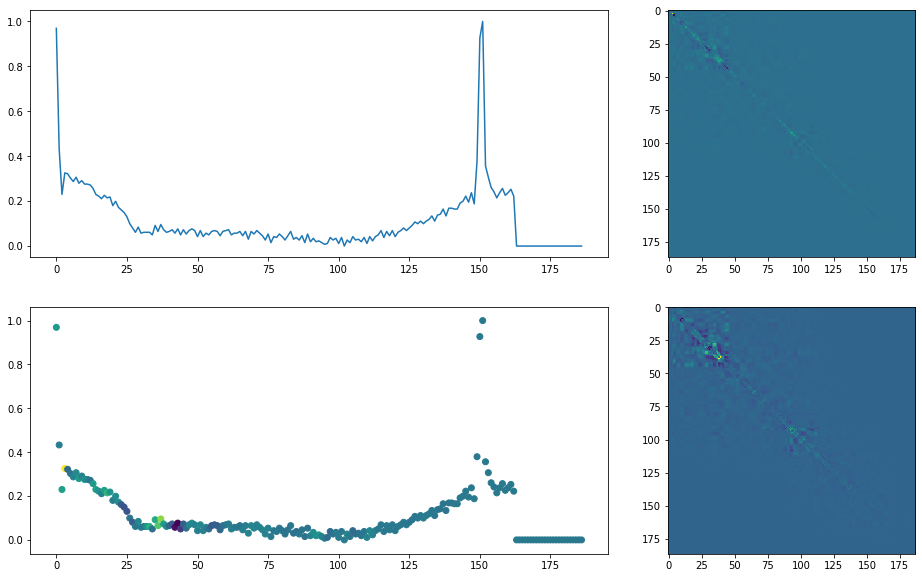

In [9]:
c = 1
i = 3
fig = plt.figure(figsize=(16, 10))
gs = mpl.gridspec.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[1, 0:2])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 2])

ax1.plot(np.arange(batch_inputs_by_class.shape[-1]),
            batch_inputs_by_class[c, i])
ax2.scatter(x=np.arange(batch_inputs_by_class.shape[-1]),
               y=batch_inputs_by_class[c, i],
               c=attributions_by_class[c, i])

zero_diagonal_interactions = interactions_by_class[c, i].copy()
np.fill_diagonal(zero_diagonal_interactions, 0.0)
ax3.imshow(interactions_by_class[c, i])
ax4.imshow(zero_diagonal_interactions)

In [10]:
def bin_dimensions(array, join_ranges):
    array = array.copy()
    delete_slices = []
    for join_range in join_ranges:
        array[:, :, join_range[0]] = np.sum(array[:, :, join_range[0]:join_range[1]], axis=2)
        delete_slices.append(np.arange(join_range[0] + 1, join_range[1]))

    delete_slices = np.concatenate(delete_slices, axis=0)
    array = np.delete(array, delete_slices, axis=2)
    return array

In [11]:
def bin_dimensions_matrix(array, join_ranges):
    array = array.copy()
    delete_slices = []
    for join_range in join_ranges:
        array[:, :, join_range[0], :] = np.sum(array[:, :, join_range[0]:join_range[1], :], axis=2)
        array[:, :, :, join_range[0]] = np.sum(array[:, :, :, join_range[0]:join_range[1]], axis=3)
        delete_slices.append(np.arange(join_range[0] + 1, join_range[1]))

    delete_slices = np.concatenate(delete_slices, axis=0)

    array = np.delete(array, delete_slices, axis=2)
    array = np.delete(array, delete_slices, axis=3)
    return array

In [97]:
num_bins = 15
step = int(np.ceil(187 / num_bins))
bins = [(i * step, min(187, (i + 1) * step)) for i in range(num_bins)]
binned_attributions_by_class = bin_dimensions(attributions_by_class, bins)
binned_interactions_by_class = bin_dimensions_matrix(interactions_by_class, bins)

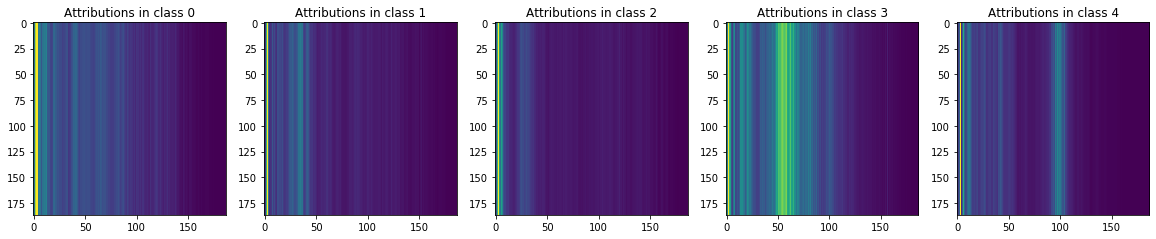

In [105]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    mean_interactions_by_class = np.mean(np.abs(attributions_by_class[i]), axis=0)
    ax = axs[i]
    ax.imshow(np.tile(np.expand_dims(mean_interactions_by_class, axis=0), reps=(187, 1)))
    ax.set_title('Attributions in class {}'.format(i))

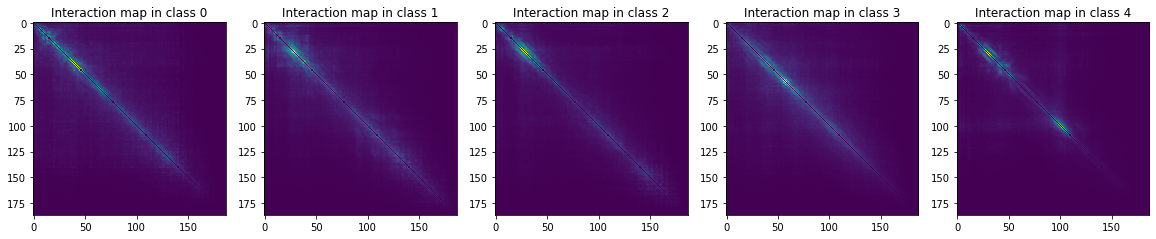

In [72]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    mean_interactions_by_class = np.mean(np.abs(interactions_by_class[i]), axis=0)
    zeroed_mean_interactions_by_class = mean_interactions_by_class.copy()
    np.fill_diagonal(zeroed_mean_interactions_by_class, 0.0)
    ax = axs[i]
    ax.imshow(zeroed_mean_interactions_by_class)
    ax.set_title('Interaction map in class {}'.format(i))

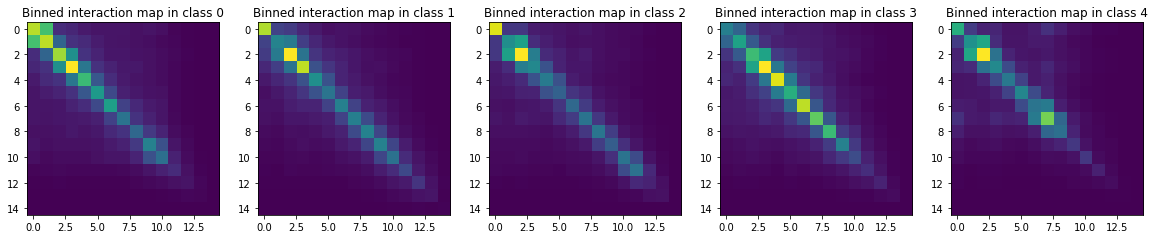

In [98]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax = axs[i]
    ax.imshow(np.mean(np.abs(binned_interactions_by_class[i]), axis=0))
    ax.set_title('Binned interaction map in class {}'.format(i))

In [27]:
def get_bin_summary_statistics(array, join_ranges):
    mean = []
    sd = []
    maximum = []
    minimum = []
    max_range = []
    skewness = []
    kurtosis = []

    for join_range in join_ranges:
        ranged_array = array[:, :, join_range[0]:join_range[1]]

        mean.append(np.mean(ranged_array, axis=-1))
        sd.append(np.std(ranged_array, axis=-1))
        maximum.append(np.max(ranged_array, axis=-1))
        minimum.append(np.min(ranged_array, axis=-1))
        max_range.append(np.max(ranged_array, axis=-1) - np.min(ranged_array, axis=-1))
        skewness.append(scipy.stats.skew(ranged_array, axis=-1))
        kurtosis.append(scipy.stats.kurtosis(ranged_array, axis=-1))

    stats_dict = {
        'mean': np.stack(mean, axis=-1),
        'sd': np.stack(sd, axis=-1),
        'maximum': np.stack(maximum, axis=-1),
        'minimum': np.stack(minimum, axis=-1),
        'range': np.stack(max_range, axis=-1),
        'skewness': np.stack(skewness, axis=-1),
        'kurtosis': np.stack(kurtosis, axis=-1)
    }

    return stats_dict

In [43]:
binned_attribution_stats_by_class = get_bin_summary_statistics(attributions_by_class, bins)

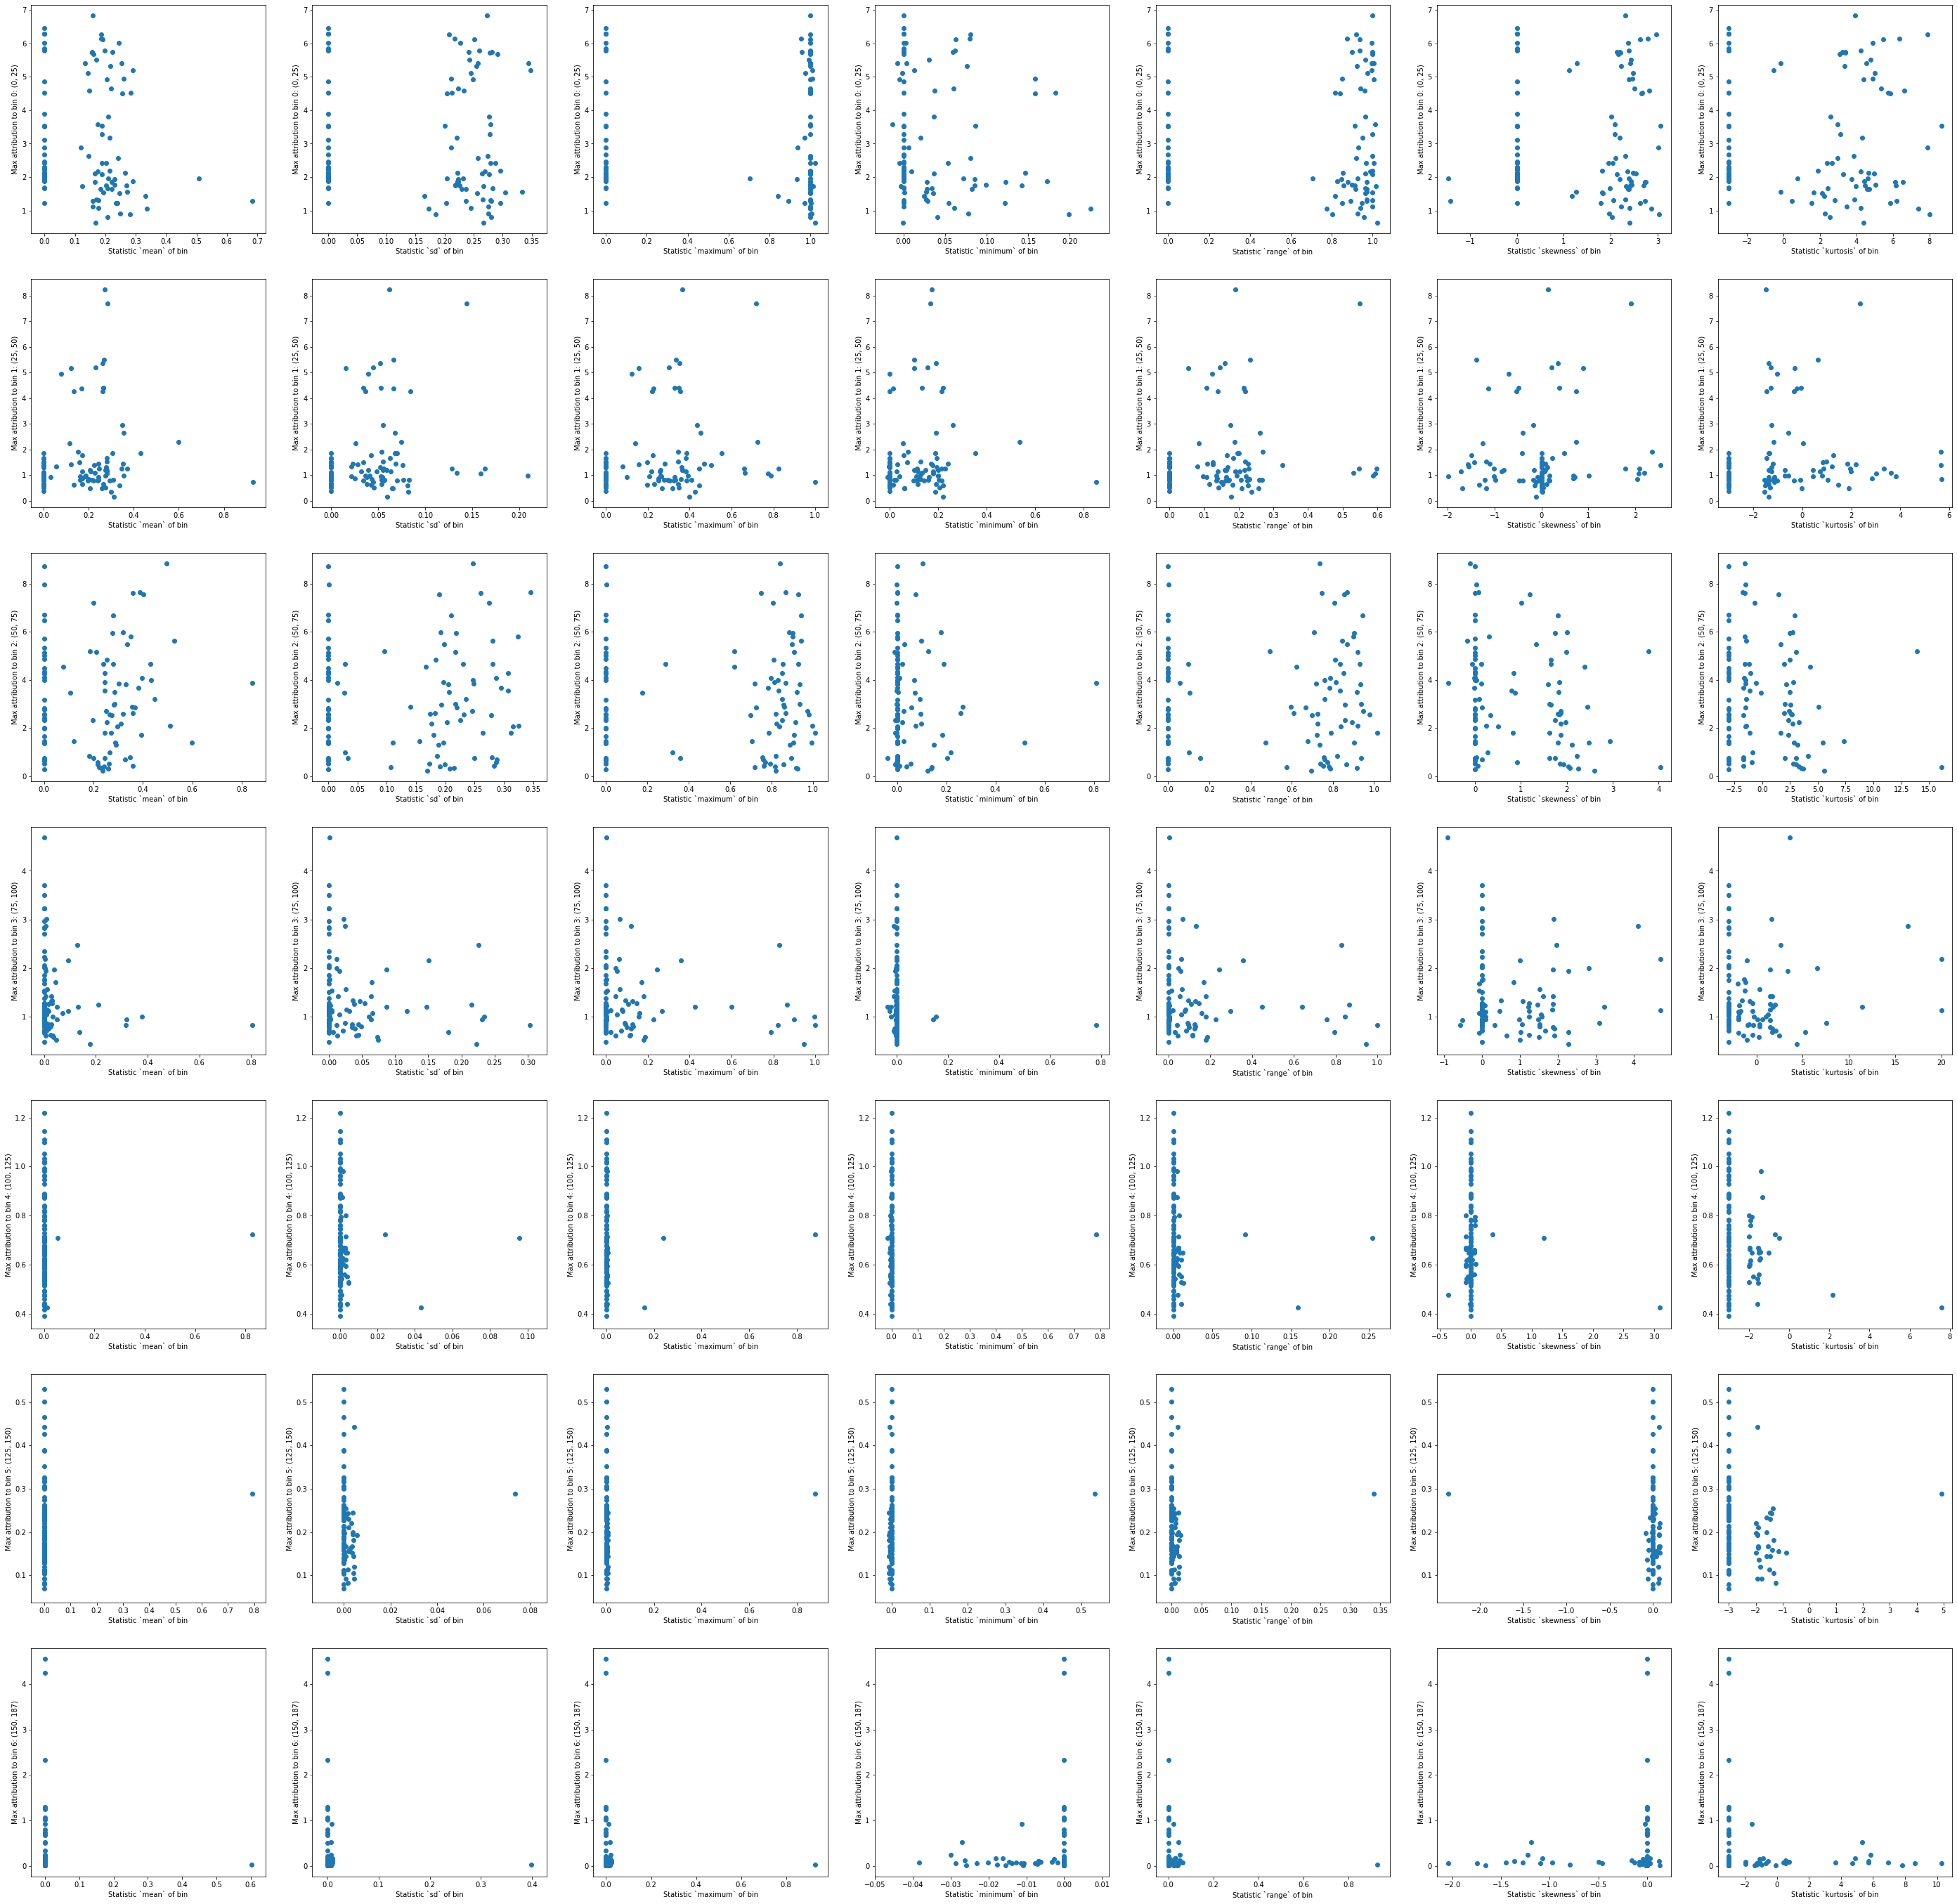

In [50]:
c = 3

fig, axs = plt.subplots(7, 7, figsize=(49, 49))

for i in range(7):
    for j, stat in enumerate(binned_input_stats_by_class.keys()):
        ax = axs[i, j]
        ax.set_xlabel('Statistic `{}` of bin'.format(stat))
        ax.set_ylabel('Max attribution to bin {}: ({}, {})'.format(i, bins[i][0], bins[i][1]))

        ax.scatter(binned_input_stats_by_class[stat][c, :, i],
                   binned_attribution_stats_by_class['maximum'][c, :, i])

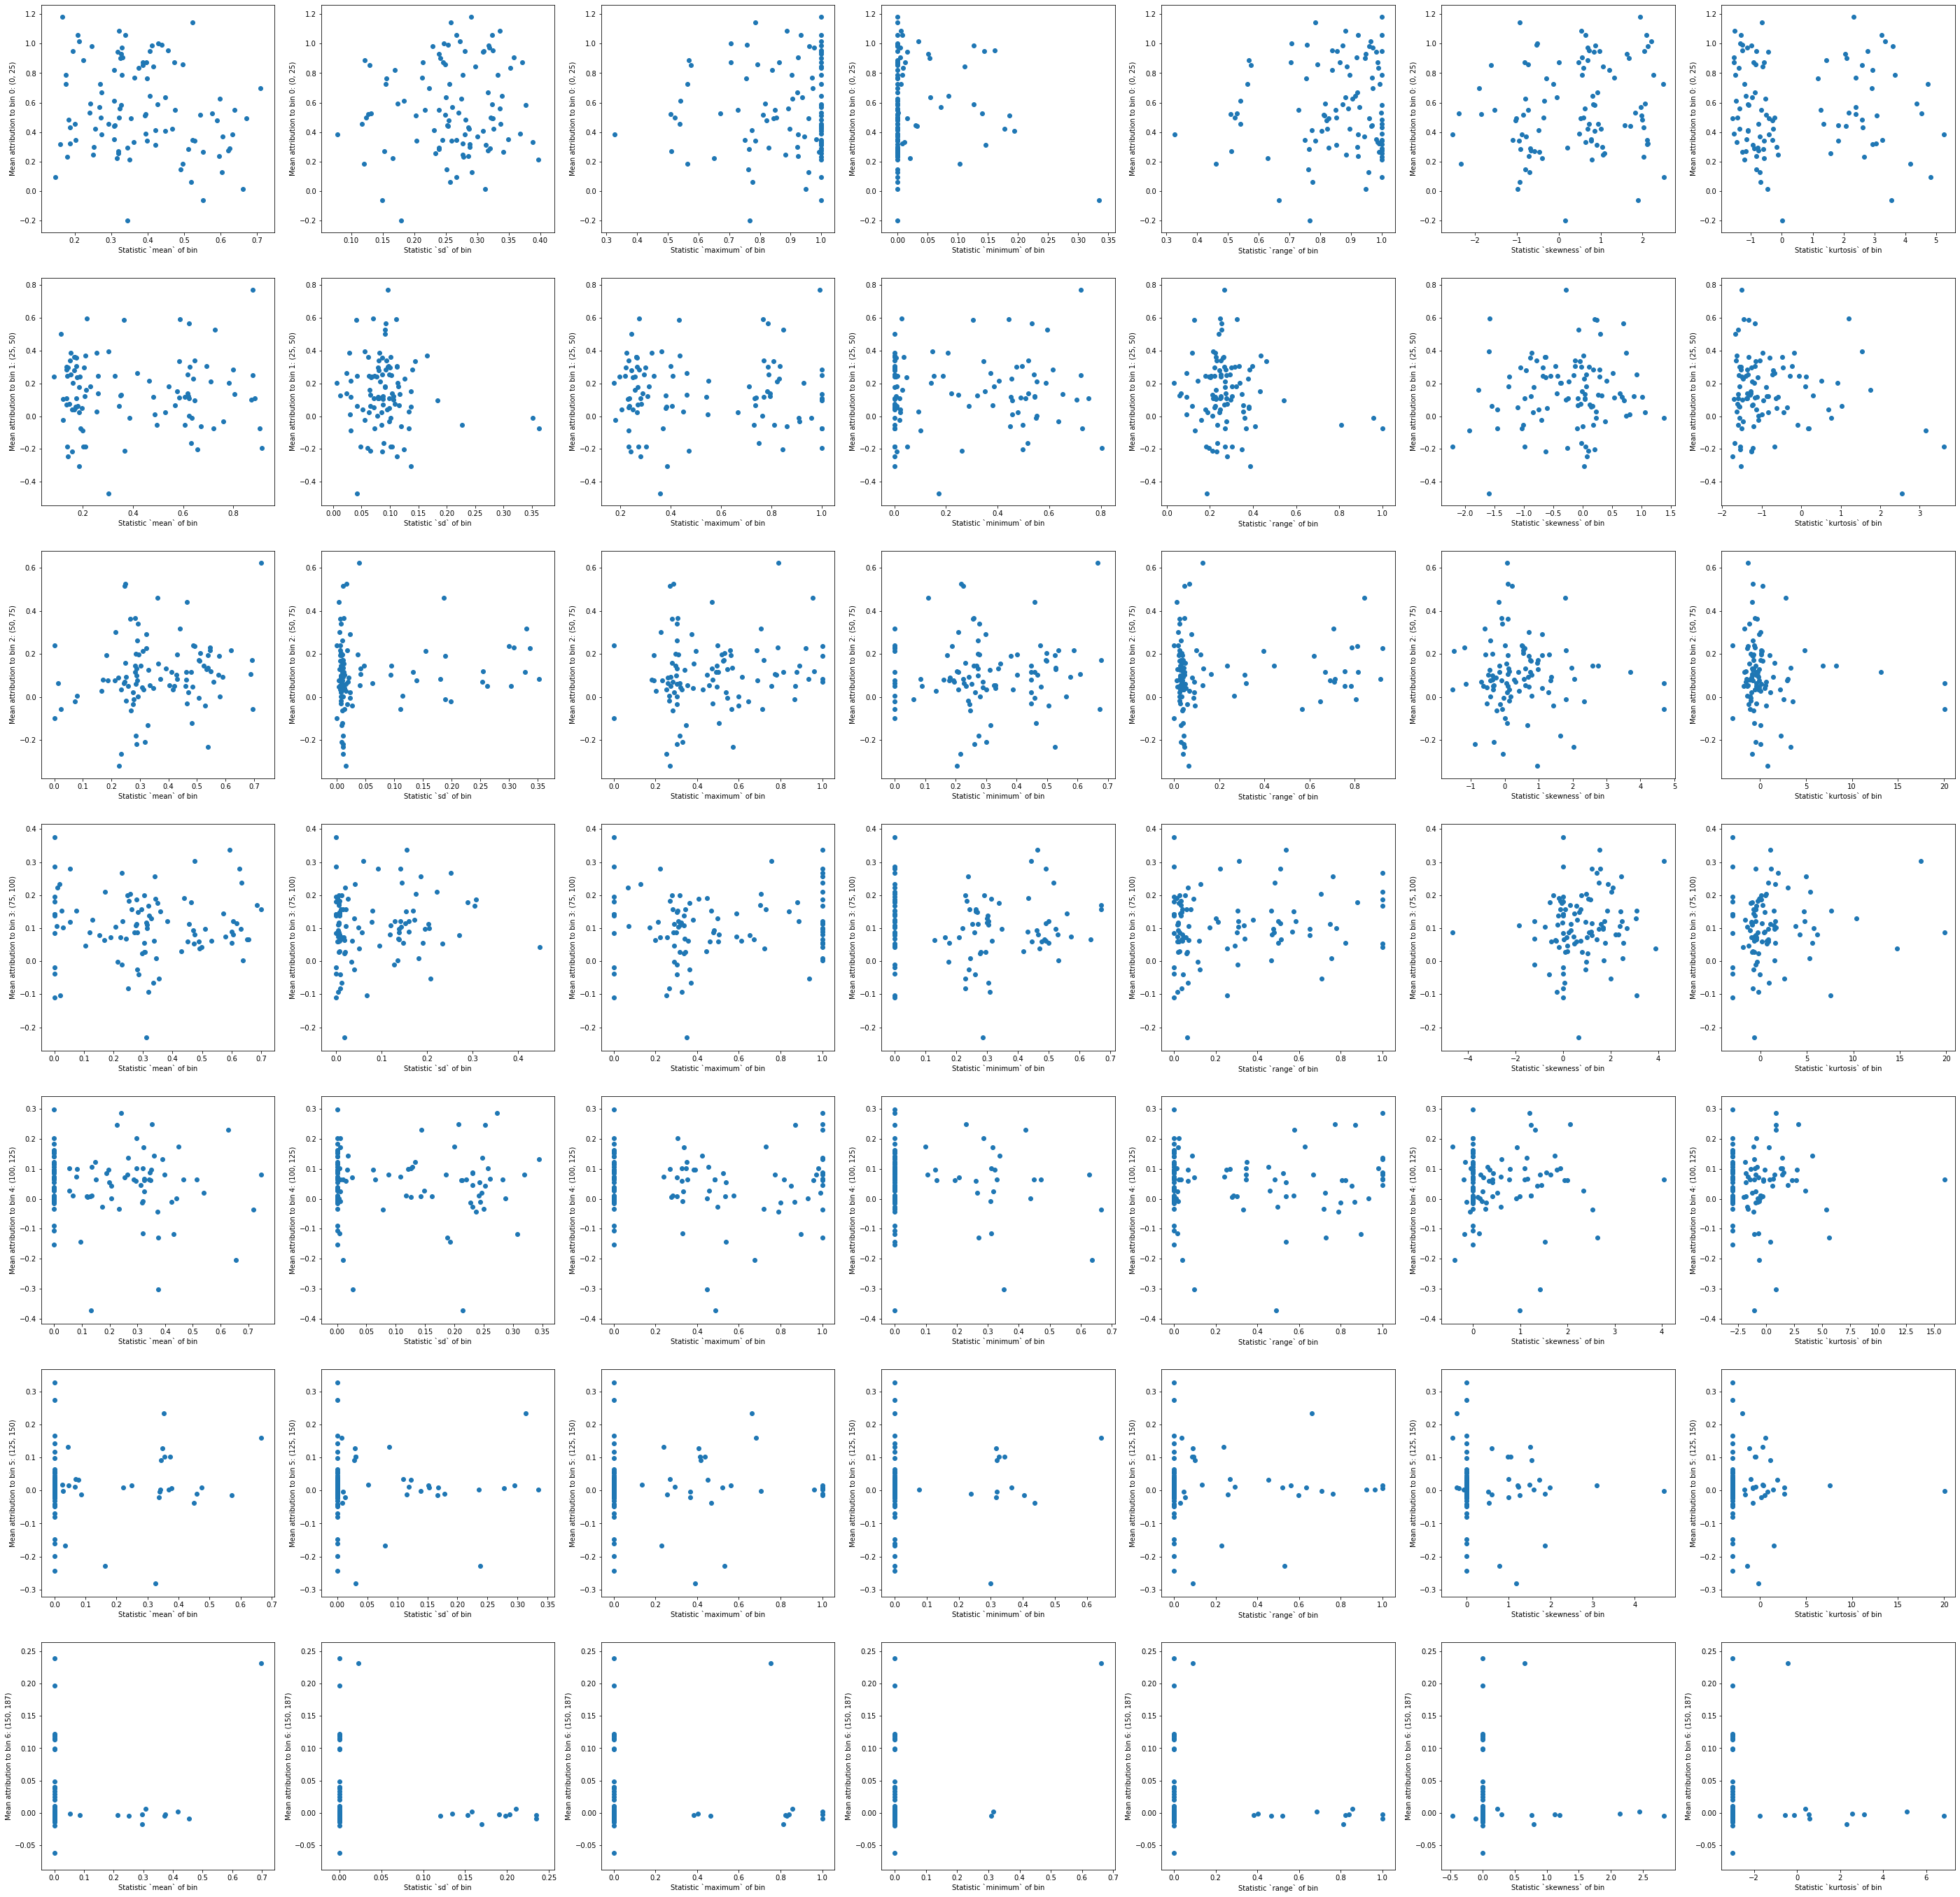

In [47]:
c = 2

fig, axs = plt.subplots(7, 7, figsize=(49, 49))

for i in range(7):
    for j, stat in enumerate(binned_input_stats_by_class.keys()):
        ax = axs[i, j]
        ax.set_xlabel('Statistic `{}` of bin'.format(stat))
        ax.set_ylabel('Mean attribution to bin {}: ({}, {})'.format(i, bins[i][0], bins[i][1]))

        ax.scatter(binned_input_stats_by_class[stat][c, :, i],
                   binned_attribution_stats_by_class['mean'][c, :, i])